## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

c:\Users\harsh\mambaforge\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.11.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
import warnings
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

# %config IPCompleter.use_jedi = False
%matplotlib inline

np.set_printoptions(precision=2, suppress=True)
plt.style.use("ggplot")

In [3]:
SEED = 2020_2024

np.random.seed(SEED)
tf.random.set_seed(SEED)


## Loading Data

In [4]:
X_data, X_sg,X_pca, y_data = np.load("combined_data.npz").values()

In [5]:
X_columns = [f"W{x}" for x in np.arange(350, 2501, 10)]
y_columns = ["PHH2O", "PHKCL", "CA", "MG", "NA", "K", "CLAY", "ORGC"]


In [6]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_data, y_data, train_size=0.70)
X_test_orig, X_valid_orig, y_test_orig, y_valid_orig = train_test_split(X_test_orig, y_test_orig, train_size=0.50)


X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split(X_sg, y_data, train_size=0.70)
X_test_sg, X_valid_sg, y_test_sg, y_valid_sg = train_test_split(X_test_sg, y_test_sg, train_size=0.50)


In [7]:
BATCH_SIZE=16

train_sg_ds = tf.data.Dataset.from_tensor_slices((X_train_sg, y_train_sg)).batch(BATCH_SIZE)
valid_sg_ds = tf.data.Dataset.from_tensor_slices((X_test_sg, y_test_sg)).batch(BATCH_SIZE)
test_sg_ds = tf.data.Dataset.from_tensor_slices((X_valid_sg, y_valid_sg)).batch(BATCH_SIZE)

train_orig_ds = tf.data.Dataset.from_tensor_slices((X_train_orig, y_train_orig)).batch(BATCH_SIZE)
valid_orig_ds = tf.data.Dataset.from_tensor_slices((X_test_orig, y_test_orig)).batch(BATCH_SIZE)
test_orig_ds = tf.data.Dataset.from_tensor_slices((X_valid_orig, y_valid_orig)).batch(BATCH_SIZE)

## Models

In [8]:
def show_performance(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"Overall:\tR2={r2:.2f}\tMSE={mse:.2f}")

    for i in range(8):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        print(f"{y_columns[i]}:\tR2={r2:.2f}\tMSE={mse:.2f}")


### MLP

In [9]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train_sg)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(216, 1)),
    normalizer,

    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.1),

    tf.keras.layers.Dense(8, activation=None)
])


In [10]:
model.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=[tfa.metrics.RSquare()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 216)               0         
                                                                 
 normalization (Normalizatio  (None, 216)              433       
 n)                                                              
                                                                 
 dense (Dense)               (None, 512)               111104    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [11]:
history = model.fit(
    train_sg_ds,
    epochs=50,
    validation_data=valid_sg_ds,
    shuffle=1,
    verbose=1
)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\engine\training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\engine\training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\engine\training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\engine\training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\engine\training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\harsh\mambaforge\lib\site-packages\keras\losses.py", line 1500, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 8 and 20 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/dense_6/BiasAdd, Cast)' with input shapes: [?,8], [?,20].


NameError: name 'history' is not defined

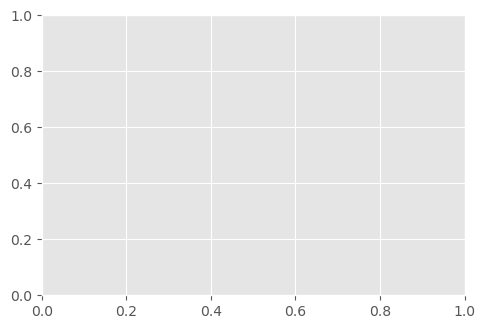

In [12]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(np.arange(50), history.history['loss'], label='Training Loss')
plt.plot(np.arange(50), history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(np.arange(50)[5:], history.history['r_square'][5:], label='Training $R^2$')
plt.plot(np.arange(50)[5:], history.history['val_r_square'][5:], label='Validation $R^2$')
plt.legend()
plt.grid()
plt.title('$R^2$ Evolution')

plt.show()

In [ ]:
y_pred = model.predict(X_test_sg)

show_performance(y_test_sg, y_pred)

17/17 [==============================] - 0s 5ms/step
Overall:	R2=0.43	MSE=23.50
PHH2O:	R2=0.57	MSE=0.87
PHKCL:	R2=0.53	MSE=0.80
CA:	R2=0.72	MSE=80.02
MG:	R2=0.65	MSE=8.09
NA:	R2=0.10	MSE=2.95
K:	R2=0.12	MSE=0.25
CLAY:	R2=0.82	MSE=92.80
ORGC:	R2=-0.07	MSE=2.23


### CNN ( No Preprocessing)

In [ ]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train_orig)

model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(216, 1)),
    tf.keras.layers.Input(shape=(216, 1)),
    normalizer,

    tf.keras.layers.Conv1D(filters=512, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=1),

    tf.keras.layers.Conv1D(filters=256, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=1),

    tf.keras.layers.Conv1D(filters=128, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=1),

    tf.keras.layers.Conv1D(filters=64, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=1),

    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2, activation="relu"),
    tf.keras.layers.MaxPool1D(pool_size=2, strides=1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(8, activation=None)
])


In [ ]:
model.compile(optimizer="rmsprop", loss="mean_squared_error", metrics=[tfa.metrics.RSquare()])
model.summary()


In [ ]:
history = model.fit(
    train_orig_ds,
    epochs=50,
    validation_data=valid_orig_ds,
    shuffle=1,
    verbose=1
)

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(np.arange(50), history.history['loss'], label='Loss')
plt.plot(np.arange(50), history.history['val_loss'], label='Validation Loass')
plt.legend()
plt.grid()
plt.title('Loss evolution')

plt.subplot(2, 2, 2)
plt.plot(np.arange(50)[5:], history.history['r_square'][5:], label='$R^2$')
plt.plot(np.arange(50)[5:], history.history['val_r_square'][5:], label='Validation $R^2$')
plt.legend()
plt.grid()
plt.title('$R^2$ Evolution')

plt.show()

In [ ]:
y_pred = model.predict(X_test_orig)

show_performance(y_test_orig, y_pred)